In [ ]:
# @title Data retrieval
import os, requests
from HelperFunctions import path_check

fname = 'memory_nback.npz'
url = "https://osf.io/xfc7e/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
        
# @title Install packages (`nilearn`, `nimare`, `duecredit`), import `matplotlib` and set defaults
# install packages to visualize brains and electrode locations
!pip install nilearn --quiet
!pip install nimare --quiet
!pip install duecredit --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True



#title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']
#print(alldat.shape)
for i in range(5):
    print((alldat[1][i])['expinfo'])
# Select just one of the recordings here. This is subject 1, block 1.

#dat3 = alldat[2][1]
#dat2 = alldat[1][1]
#dat1 = alldat[0][1]
print(type((alldat[0][1])['locs']))


fixation
0-back
1-back
2-back
fixation
<class 'numpy.ndarray'>


In [ ]:
cwd = os.getcwd()
print(cwd)
OutPath = '/Users/mairahmac/course-content-main/projects/ECoG/Code/Output'
path_check.path_check(OutPath)
#os.chdir(InPath)

/Users/mairahmac/course-content-main/projects/ECoG/Code
Directory  /Users/mairahmac/course-content-main/projects/ECoG/Code/Output  already exists


/var/folders/nb/qns58gm53h1btptlry8cnm640000gn/T/ipykernel_44927/1210840644.py:35: RuntimeWarning: Mean of empty slice.
  V_resp = (V_epochs[dat['response'] == 1]).mean(0)
/Users/mairahmac/opt/anaconda3/envs/NMA/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/var/folders/nb/qns58gm53h1btptlry8cnm640000gn/T/ipykernel_44927/1210840644.py:35: RuntimeWarning: Mean of empty slice.
  V_resp = (V_epochs[dat['response'] == 1]).mean(0)
/Users/mairahmac/opt/anaconda3/envs/NMA/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


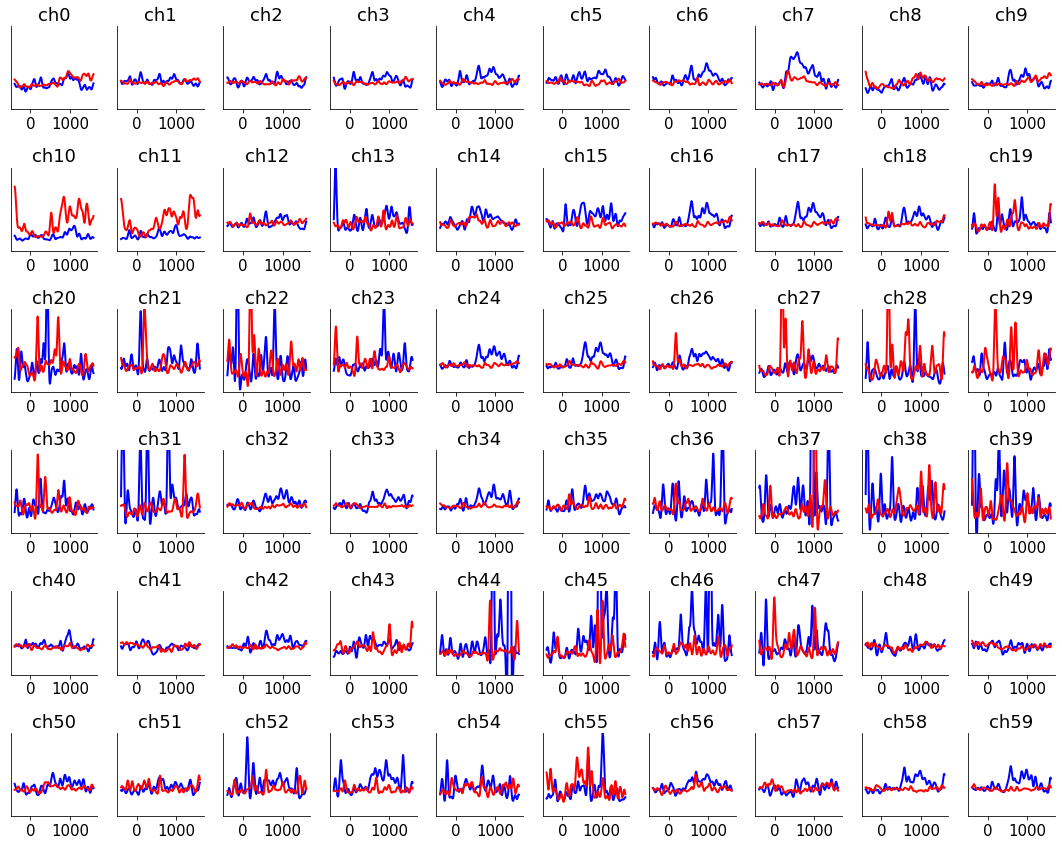

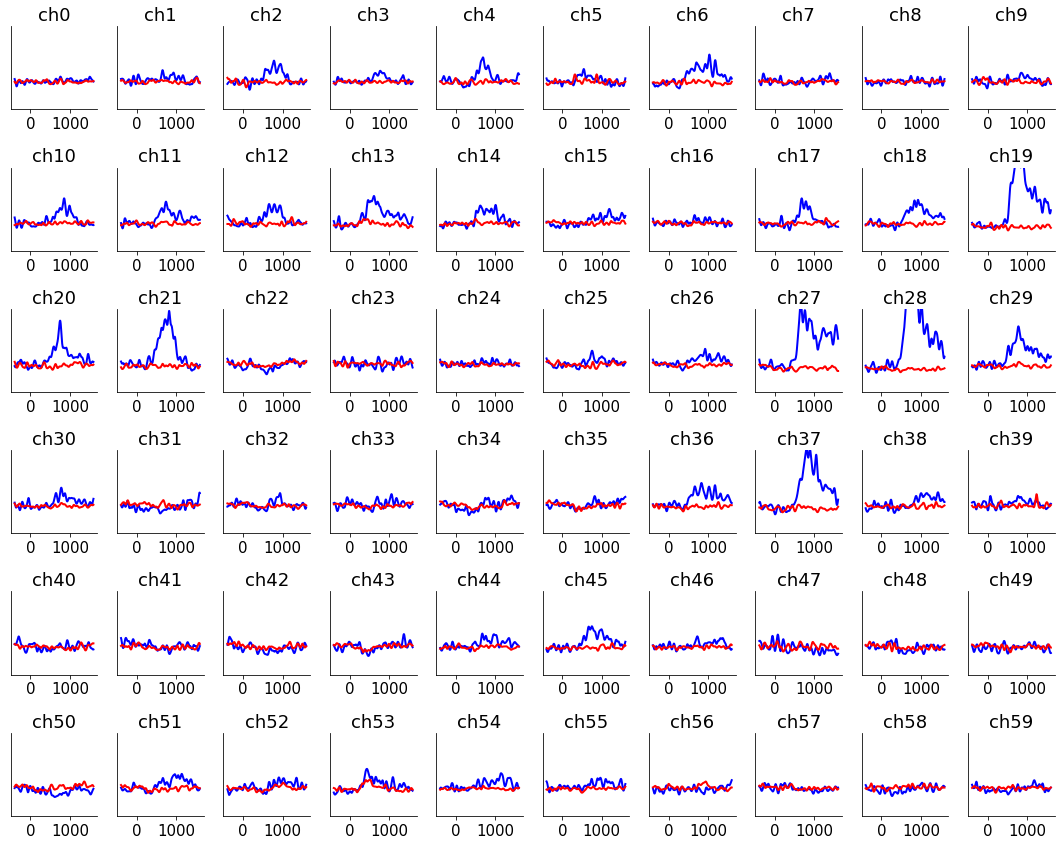

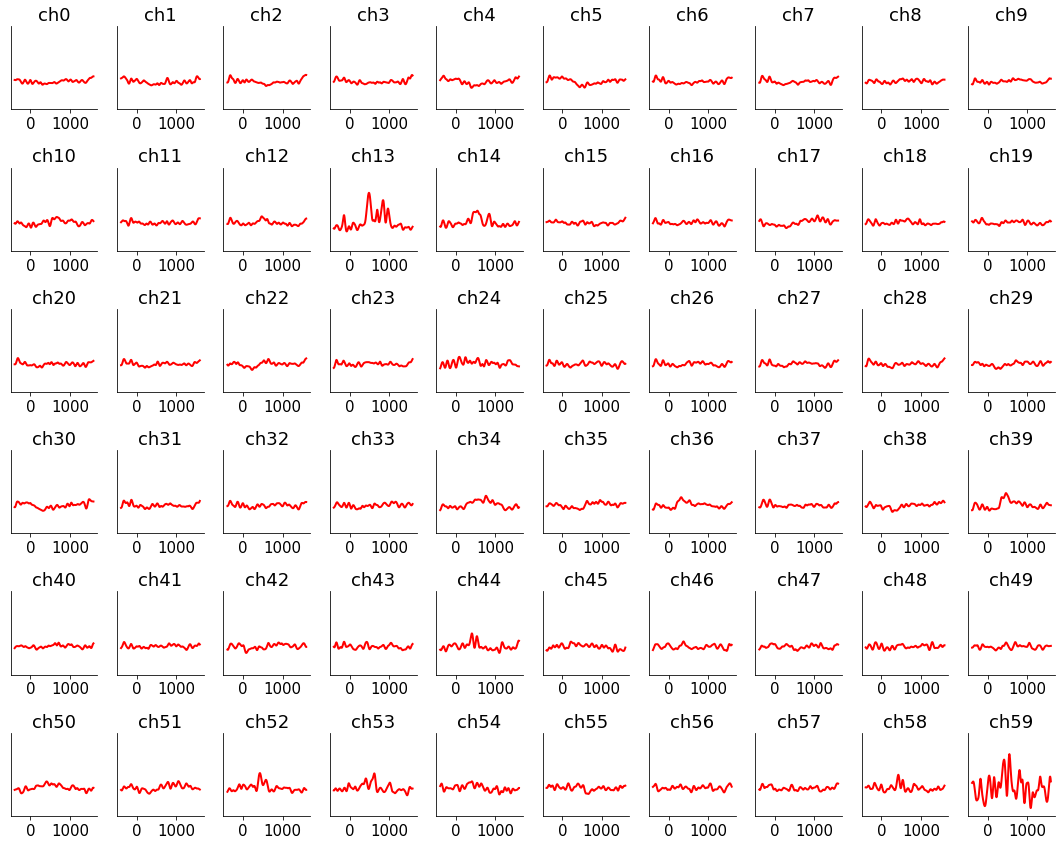

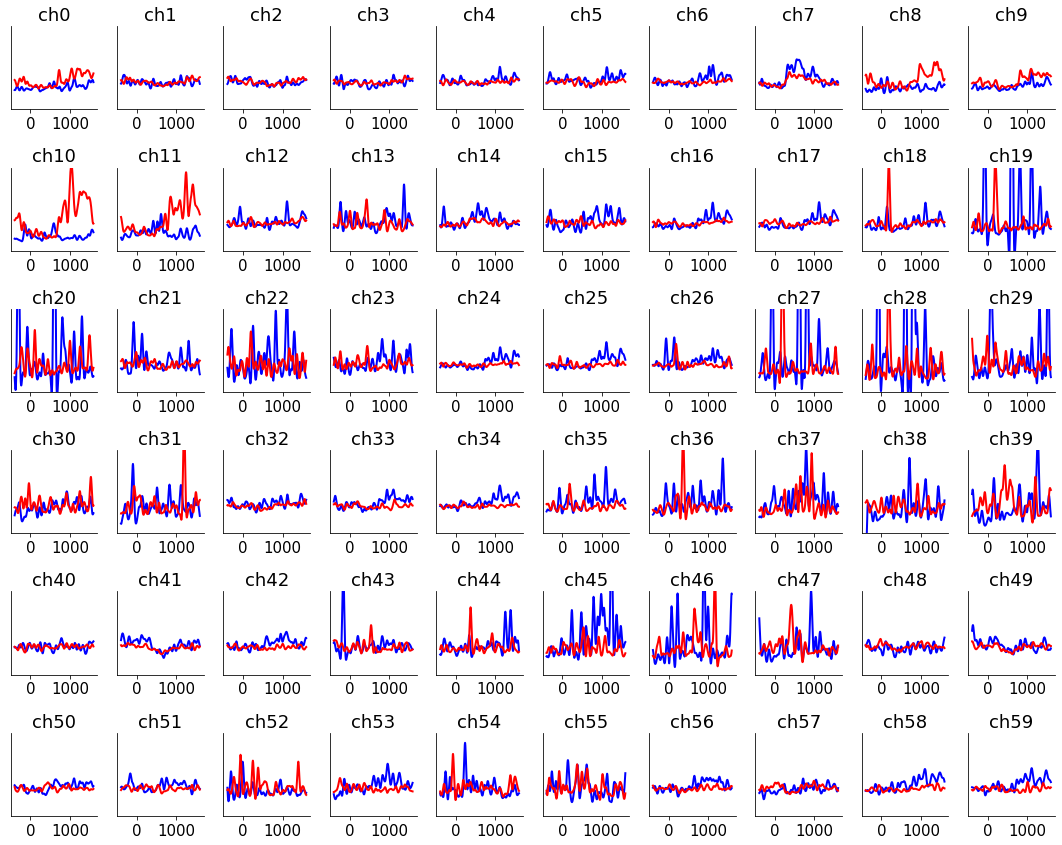

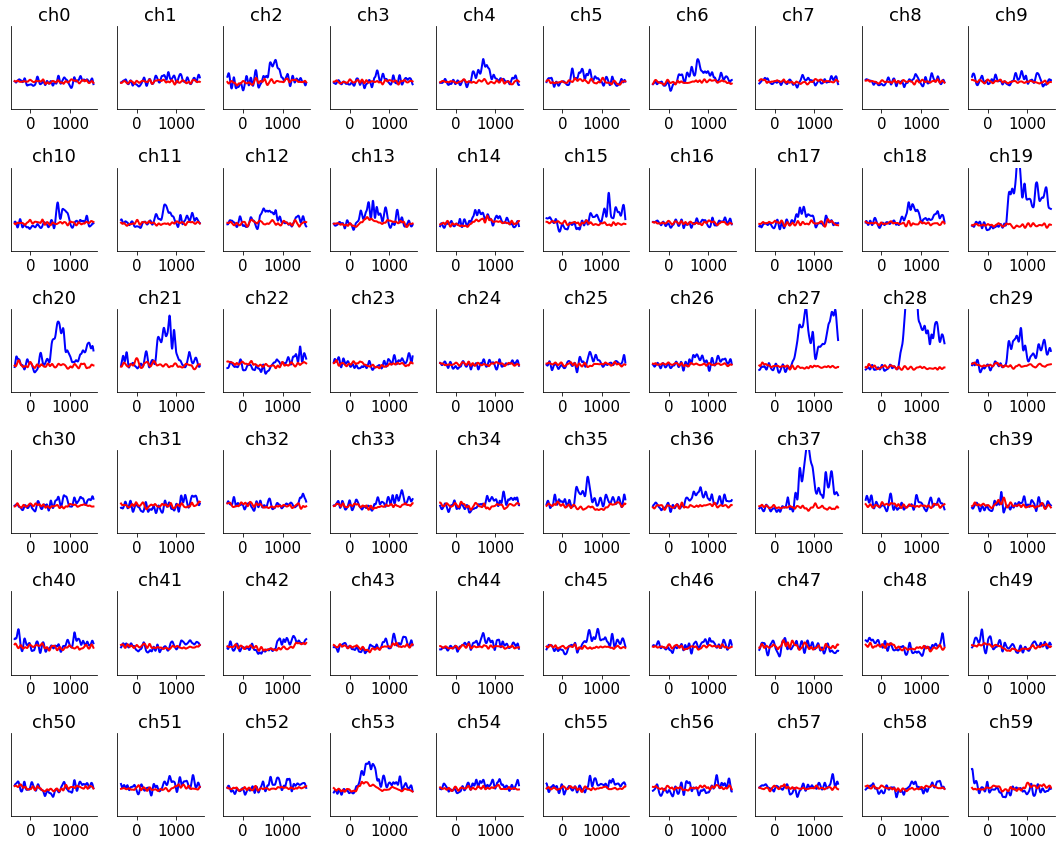

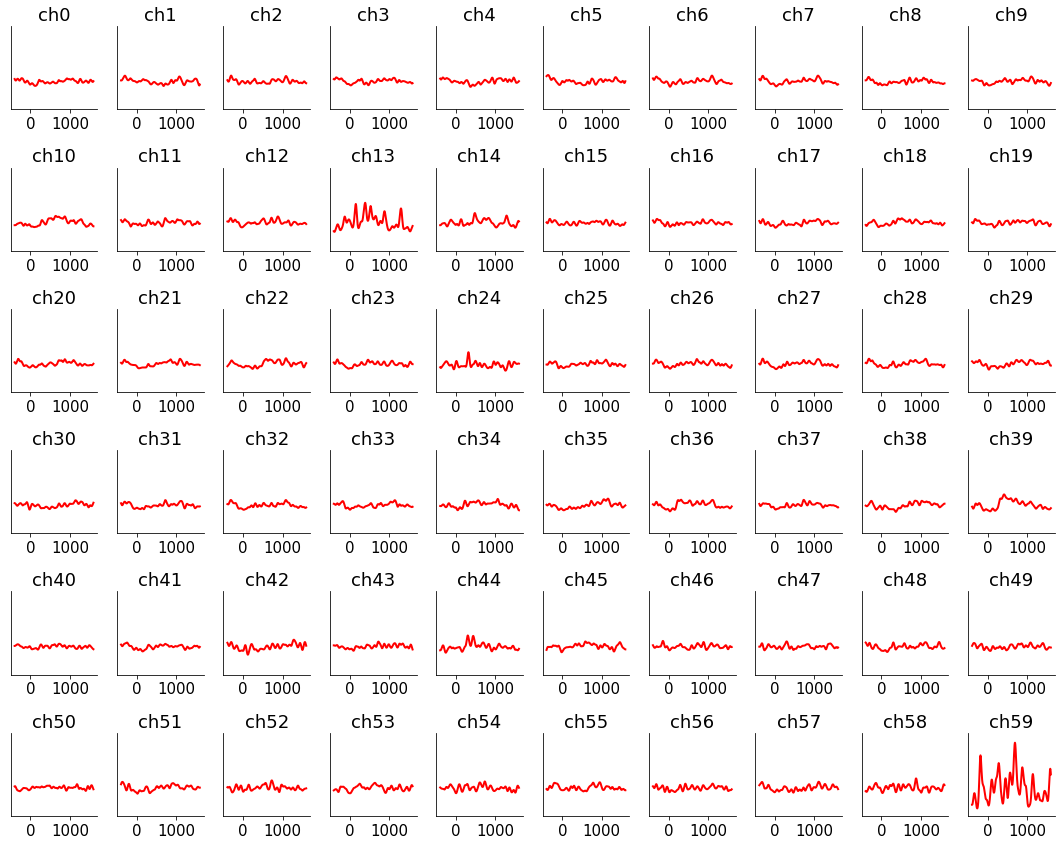

In [ ]:
# compute spectral power above 50Hz and low-pass below 10Hz
# power is always positive, so we normalize it by its average
from scipy import signal

# pick subject 1 and experiment 1
for m in range(len(alldat)):
    for i in range(len(alldat)):
        
        dat = (alldat[i][m])
        if dat['expinfo'] != 'fixation':
            blocktype = dat['expinfo']
            V = dat['V'].astype('float32') # always convert the voltage data to float32!

            # high-pass filter above 50 Hz
            b, a = signal.butter(3, [50], btype='high', fs=1000)
            V = signal.filtfilt(b, a, V, 0)

            # compute smooth envelope of this signal = approx power
            V = np.abs(V)**2
            b, a = signal.butter(3, [10], btype='low', fs=1000)
            V = signal.filtfilt(b, a, V, 0)

            # normalize each channel so its mean power is 1
            V = V/V.mean(0)

            # divide into trials and average
            nt, nchan = V.shape
            nstim = len(dat['t_on'])

            # use a timerange from 400ms before to 1600ms after the stimulus onset
            trange = np.arange(-400, 1600)
            ts = dat['t_on'][:, np.newaxis] + trange
            V_epochs = np.reshape(V[ts, :], (nstim, 2000, nchan))

            V_resp = (V_epochs[dat['response'] == 1]).mean(0)
            V_base = (V_epochs[dat['response'] == 0]).mean(0)


            # let's find the electrodes that distinguish responses from non-responses
            # note these are event-related potentials
            figname = OutPath + '/Sub_' + str(i) + '_' + blocktype + '.jpg'
            plt.figure(figsize=(15, 12))
            for j in range(60):
              ax = plt.subplot(6, 10, j+1)
              plt.plot(trange, V_resp[:, j], lw=2, color='blue')
              plt.plot(trange, V_base[:, j], lw=2, color='red')
              plt.title('ch%d'%j)
              plt.yticks([])
              plt.ylim([0, 3])
            plt.savefig(figname)


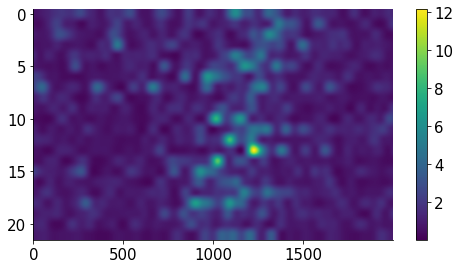

In [ ]:
# let's look at all the response trials for the electrode that has a significant response
plt.subplot(1, 3, 1)
plt.imshow(V_epochs[dat['response']==1, :, 21].astype('float32'),
           aspect='auto')
plt.colorbar()
plt.show()

In [ ]:
# to do: do these responses covary with the reaction times? are they present on trials where there is no motor response?